## Imports



In [1]:
!pip install scikit-survival -q
!pip install xgboost -q
!pip install lifelines -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 7.3 MB/s eta 0:00:00


In [2]:
from sklearn import set_config
from sklearn.model_selection import train_test_split

from sksurv.datasets import get_x_y
from sksurv.preprocessing import OneHotEncoder

set_config(display="text")

In [3]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis


random.seed(42)
np.random.seed(42)

## Dataset



In [4]:
data= pd.read_csv('METABRIC_RNA_Mutation.csv')

<ipython-input-4-0dffe3543454>:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv('METABRIC_RNA_Mutation.csv')


In [ ]:
#list(data.columns)

In [5]:
data["event"]=0
data.loc[(data.death_from_cancer=="Died of Disease"),"event"]=1
data[['overall_survival_months', 'overall_survival', 'event']]

,overall_survival_months,overall_survival,event
0,140.500000,1,0
1,84.633333,1,0
2,163.700000,0,1
3,164.933333,1,0
4,41.366667,0,1
...,...,...,...
1899,196.866667,1,0
1900,44.733333,0,1
1901,175.966667,0,1
1902,86.233333,0,0


In [6]:
data = data.drop(['patient_id', 'type_of_breast_surgery', 'inferred_menopausal_state', 'integrative_cluster', 'lymph_nodes_examined_positive', 'oncotree_code', 'tumor_stage', 'overall_survival' , 'death_from_cancer',
       'cancer_type', 'cancer_type_detailed',  'cohort', 'er_status_measured_by_ihc', 'her2_status_measured_by_snp6', 'nottingham_prognostic_index', '3-gene_classifier_subtype', 'primary_tumor_laterality', 'tumor_other_histologic_subtype', 'mutation_count' ], axis=1)

nan_cols = data.columns[data.isna().sum()>0]
print(data[nan_cols].isna().sum())

data.fillna(value=0, inplace=True)

cellularity                  54
neoplasm_histologic_grade    72
tumor_size                   20
dtype: int64


In [ ]:
#data[list(data.columns)[:12]].nunique()
#data.cellularity.value_counts()
#data["pam50_+_claudin-low_subtype"].value_counts()

In [7]:
data["cellularity"] = data["cellularity"].replace({"Low": 1, "Moderate":2, "High":3})
data=data.replace({"Negative": 0, "Positive": 1})

cat = pd.get_dummies(data[["pam50_+_claudin-low_subtype"]]).replace({False: 0, True: 1}).drop("pam50_+_claudin-low_subtype_NC", axis=1)
data = pd.concat([data.drop("pam50_+_claudin-low_subtype", axis=1), cat],axis=1)

In [8]:
df_train, df_test = train_test_split(data, test_size=0.2, shuffle = True, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle = True, random_state=42)

## Scaling and reducing multicollinearity

In [ ]:
features = [i for i in data.columns if data[i].dtype!='object' and i not in ["event", "overall_survival_months"]]
reducing = df_train[features]

scaler = StandardScaler()
reducing[features] = scaler.fit_transform(reducing[features])

<ipython-input-11-926b7426d844>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reducing[features] = scaler.fit_transform(reducing[features])


In [ ]:
corr_matrix = reducing.corr()

to_delete = []
for i in corr_matrix.index:
  row = corr_matrix.loc[i].drop(i)
  if len(row[abs(row)>0.6])>0:
    corr_matrix = corr_matrix.drop(i,axis=1)
    to_delete.append(i)

In [ ]:
to_delete

['er_status',
 'her2_status',
 'chek2',
 'msh2',
 'pms2',
 'epcam',
 'rb1',
 'ccnb1',
 'cdk1',
 'ccne1',
 'cdc25a',
 'cdk6',
 'ccnd2',
 'cdkn1b',
 'e2f2',
 'e2f7',
 'jak1',
 'aph1a',
 'aph1b',
 'cir1',
 'heyl',
 'psen1',
 'snw1',
 'acvrl1',
 'aurka',
 'bcl2',
 'bmpr2',
 'casp8',
 'chek1',
 'csf1r',
 'eif4e',
 'erbb3',
 'folr2',
 'foxo1',
 'igf1',
 'mmp11',
 'mmp13',
 'mmp2',
 'pdgfra',
 'pdgfrb',
 'pik3ca',
 'tgfb3',
 'tgfbr2',
 'tsc2',
 'gata3',
 'kmt2c',
 'fn1',
 'adgra2',
 'col12a1',
 'col6a3',
 'kdm3a',
 'palld',
 'ppp2cb',
 'sgcd',
 'smarcc2',
 'akr1c2',
 'akr1c3']

In [ ]:
#corr_matrix.loc["er_status"][abs(corr_matrix.loc["er_status"])>0.6]

In [ ]:
reducing = reducing.drop(to_delete, axis=1)

In [ ]:
scaler = StandardScaler()
scaler.fit(df_train[reducing.columns])

df_train[reducing.columns] = scaler.transform(df_train[reducing.columns])
df_val[reducing.columns] = scaler.transform(df_val[reducing.columns])
df_test[reducing.columns] = scaler.transform(df_test[reducing.columns])

## Features selection

In [ ]:
cols = list(reducing.columns)+["event", "overall_survival_months"]

X_tree_train, y_tree_train = get_x_y(df_train[cols], ["event", "overall_survival_months"], 1)
X_tree_val, y_tree_val = get_x_y(df_val[cols], ["event", "overall_survival_months"], 1)

In [ ]:
%%time
estimator = GradientBoostingSurvivalAnalysis(loss="coxph",
                           min_samples_leaf=20 , n_estimators=30, max_features = 40).fit(X_tree_train, y_tree_train)

print(estimator.score(X_tree_train, y_tree_train))
print(estimator.score(X_tree_val, y_tree_val))

0.8402427634917823
0.7140840810565581
CPU times: user 1.28 s, sys: 1.32 ms, total: 1.28 s
Wall time: 1.28 s


In [ ]:
from sklearn.inspection import permutation_importance

result_xgb = permutation_importance(estimator, X_tree_train, y_tree_train, n_repeats=3, random_state=123)

In [ ]:
def top(model_result, data, num):
  best = pd.DataFrame(
    {k: model_result[k] for k in ("importances_mean", "importances_std",)},index=data.columns)
  best_num = best.sort_values(by="importances_mean", ascending=False).iloc[:num,:]
  return(best_num.index)

In [ ]:
top50_boost = top(result_xgb, X_tree_train, 50)

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_leaf=20,
                           n_jobs=-1,
                           random_state=123)
rsf.fit(X_tree_train, y_tree_train)

print(rsf.score(X_tree_train, y_tree_train))
print(rsf.score(X_tree_val, y_tree_val))

0.9088075339565584
0.7263837080350842


In [ ]:
result_rsf = permutation_importance(rsf, X_tree_train, y_tree_train, n_repeats=3, random_state=123)

In [ ]:
top50_rsf= top(result_rsf, X_tree_train, 50)

In [ ]:
top_intersect = np.intersect1d(top50_rsf,top50_boost)
top_intersect

array(['age_at_diagnosis', 'cdkn2a', 'chemotherapy', 'col22a1', 'cul1',
       'e2f3', 'fancd2', 'gsk3b', 'hsd3b7', 'map2k4', 'mapt', 'mmp25',
       'nr2f1', 'rad51', 'shbg', 'smad6', 'stat5a', 'stmn2', 'tumor_size',
       'ugt2b17', 'wwox'], dtype=object)

In [ ]:
final_features = np.unique(np.concatenate((top_intersect, top50_rsf[:25], top50_boost[:25])))#.shape
final_features

array(['abcb1', 'acvr1b', 'age_at_diagnosis', 'bmp10', 'bmp3', 'cdkn2a',
       'chemotherapy', 'col22a1', 'ctcf', 'cul1', 'cyp21a2', 'e2f3',
       'e2f8', 'fancd2', 'gsk3b', 'hey2', 'hsd17b8', 'hsd3b7', 'igf1r',
       'kras', 'lfng', 'map2k3', 'map2k4', 'map3k10', 'mapt', 'mmp25',
       'ncoa3', 'npnt', 'nr2f1', 'pam50_+_claudin-low_subtype_LumA',
       'prkce', 'ptpn22', 'rad51', 'shbg', 'slc29a1', 'smad5', 'smad6',
       'src', 'stat5a', 'stmn2', 'tubb4a', 'tubb4b', 'tumor_size',
       'ugt2b17', 'wwox'], dtype=object)

## Final features check for multicollinearity

<Axes: >

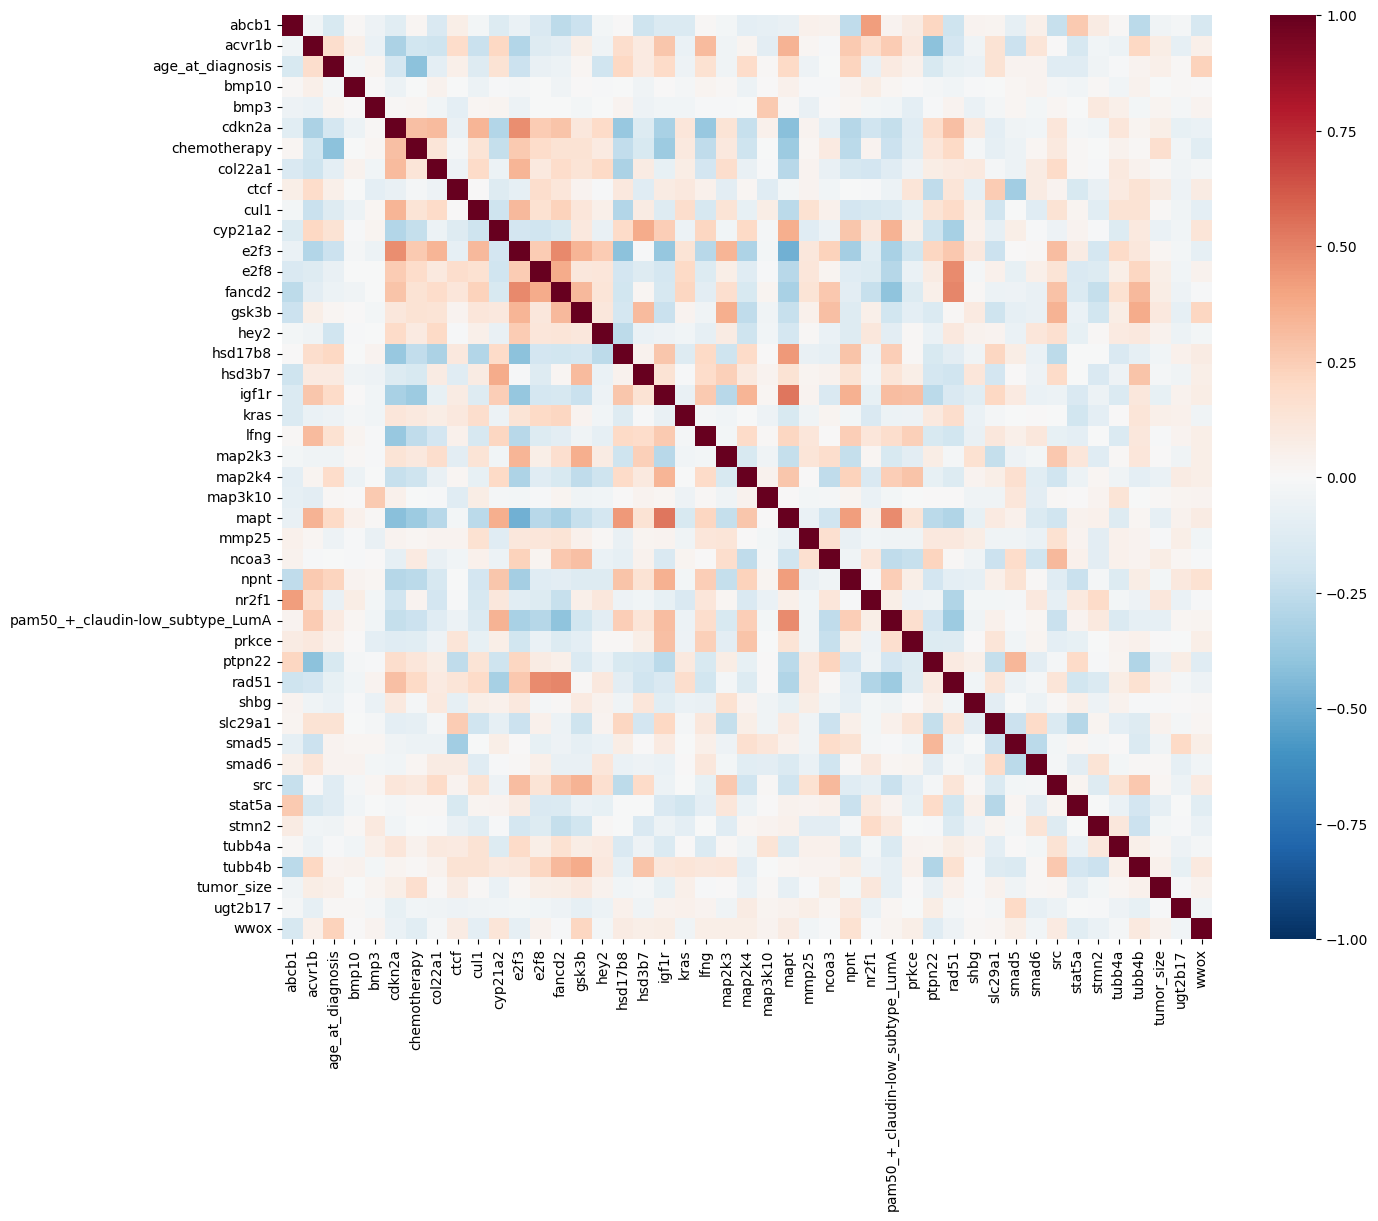

In [ ]:
import seaborn as sns
plt.figure(figsize = (15, 12))
sns.heatmap(df_train[final_features].corr(),vmin = -1, vmax = 1, annot=False, cmap="RdBu_r")

In [ ]:
df_train[list(final_features) + ["event", "overall_survival_months"]].to_csv("Metabric_train.csv")
df_test[list(final_features) + ["event", "overall_survival_months"]].to_csv("Metabric_test.csv")
df_val[list(final_features) + ["event", "overall_survival_months"]].to_csv("Metabric_val.csv")


## All data with only chosen features without scaling

In [12]:
data_selected = data[list(final_features)+["event", "overall_survival_months"]]
data_selected.to_csv("Metabric_selected.csv")